# Initialization

In [1]:
# Standard Library Imports
import pickle
import gzip
import math
import os
import time
import shutil
import sys
import gc
import traceback
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

# Third-Party Library Imports
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from datasets import load_dataset, load_dataset_builder
from torcheval.metrics import MulticlassAccuracy
import fastcore.all as fc

# PyTorch
from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
from torch.nn import init
import torch.nn.functional as F

# miniai
from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

# Fastcore
from fastcore.test import test_close

# PyTorch settings
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

# Disable logging warnings
import logging
logging.disable(logging.WARNING)

set_seed(42)

In [2]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)

In [3]:
def get_model():
    return nn.Sequential(conv(1 ,8), conv(8 ,16), conv(16,32), conv(32,64),
                         conv(64,10, act=False), nn.Flatten()).to(def_device)

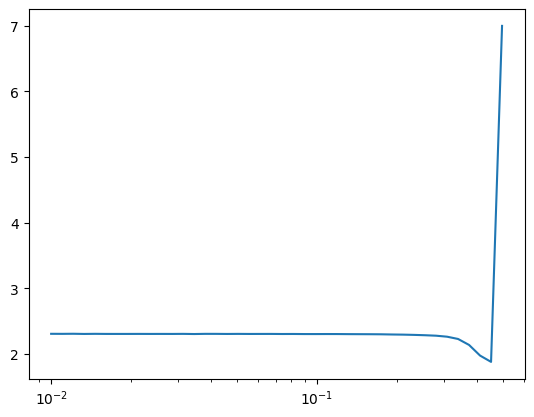

In [4]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

In [5]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]

learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.134,2.343,0,train
0.100,2.303,0,eval


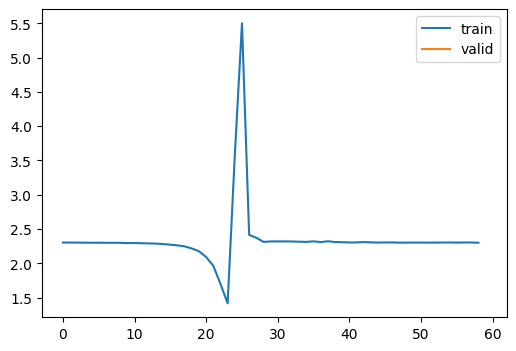

In [6]:
learn.fit(1)

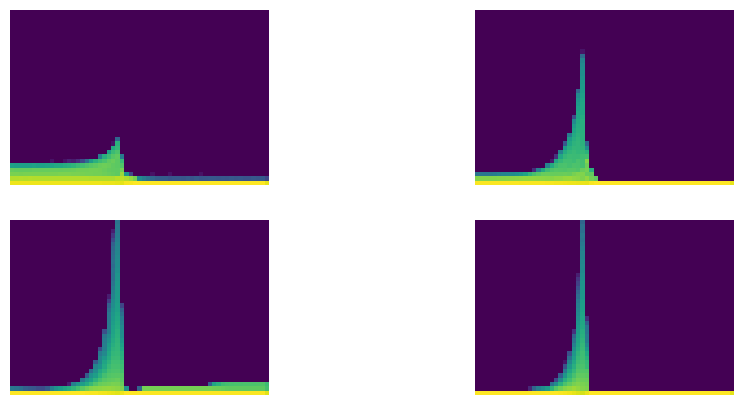

In [7]:
astats.color_dim()

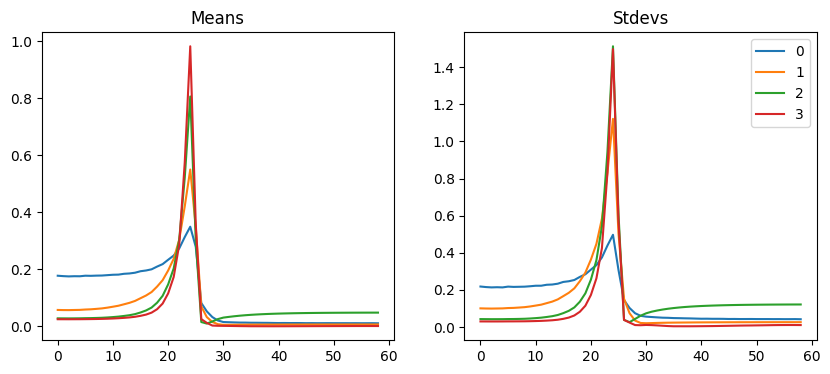

In [8]:
astats.plot_stats()

In [9]:
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

In [10]:
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

In [11]:
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

## Glorot/Xavier init

#### The Problem Xavier Initialization Solves:

In deep neural networks, especially those with many layers, the scale of weights can dramatically impact how gradients propagate during backpropagation. If the weights are initialized too large, the gradients may explode, leading to unstable updates. If the weights are initialized too small, gradients may vanish, making it difficult for the network to learn.

Xavier initialization is designed to keep the variance of activations and gradients in a manageable range as they propagate through the network.

#### The Xavier Initialization Formula:

For a neuron with $n_{\text{in}}$ input connections (number of incoming connections), the Xavier initialization sets the weights according to:

$$
W \sim \mathcal{U}\left( -\frac{1}{\sqrt{n_{\text{in}}}}, \frac{1}{\sqrt{n_{\text{in}}}} \right)
$$

Where:
- $\mathcal{U}$ is the uniform distribution.
- $n_{\text{in}}$ is the number of input neurons to a given layer.
- The weights are sampled from a uniform distribution between $-\frac{1}{\sqrt{n_{\text{in}}}}$ and $\frac{1}{\sqrt{n_{\text{in}}}}$.

Alternatively, for a normal distribution (Gaussian), the weights are initialized as:

$$
W \sim \mathcal{N}\left( 0, \frac{1}{\sqrt{n_{\text{in}}}} \right)
$$

This ensures that the variance of the activations is controlled across layers and helps prevent gradients from growing too large or too small.

---

#### When to Use Xavier Initialization:

Xavier initialization is typically used for **activation functions like Sigmoid or Tanh**.

---

#### Example in PyTorch:

In PyTorch, you can apply Xavier initialization using the built-in function `torch.nn.init.xavier_uniform_` or `torch.nn.init.xavier_normal_`.

Example code for Xavier initialization:

```python
import torch
import torch.nn as nn

# Example layer
layer = nn.Linear(in_features=256, out_features=128)

# Apply Xavier Uniform initialization
torch.nn.init.xavier_uniform_(layer.weight)

# Or apply Xavier Normal initialization
torch.nn.init.xavier_normal_(layer.weight)

In [12]:
x = torch.randn(200, 100)

for i in range(50):
    x = x @ torch.randn(100,100)

x[0:5,0:5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

The result is `nan`s everywhere. So maybe the scale of our matrix was too big, and we need to have smaller weights? But if we use too small weights, we will have the opposite problem—the scale of our activations will go from 1 to 0.1, and after 50 layers we'll be left with zeros everywhere:

In [13]:
x = torch.randn(200, 100)

for i in range(50):
    x = x @ (torch.randn(100,100) * 0.01)

x[0:5,0:5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

So we have to scale our weight matrices exactly right so that the standard deviation of our activations stays at 1. We can compute the exact value to use mathematically, as illustrated by Xavier Glorot and Yoshua Bengio in ["Understanding the Difficulty of Training Deep Feedforward Neural Networks"](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). The right scale for a given layer is $1/\sqrt{n_{in}}$, where $n_{in}$ represents the number of inputs.

In [14]:
x = torch.randn(200, 100)

for i in range(50):
    x = x @ (torch.randn(100,100) * 0.1)

x[0:5,0:5]

tensor([[-0.24, -0.20,  1.21, -0.63, -0.50],
        [-0.05, -0.15, -0.06, -0.11, -0.13],
        [-1.22, -0.06, -1.84,  0.24, -0.29],
        [-1.55, -0.18, -0.65,  0.00, -0.24],
        [ 0.34, -0.11,  1.33, -0.49, -0.45]])

## Background

#### Variance:
Variance is a measure of variability in a dataset that indicates how far a set of numbers are spread out from their average value (mean). 

Mathematically, for a dataset X with n elements, variance (σ²) is defined as:

σ² = Σ(X - μ)² / n

Where:
- X is each value in the dataset
- μ is the mean of the dataset
- n is the number of values

#### Standard Deviation:
Standard deviation is the square root of variance. It measures the amount of variation or dispersion of a set of values.

Mathematically, standard deviation (σ) is:

σ = √(σ²)

In [15]:
t = torch.tensor([1.,2.,4.,18])

In [16]:
m = t.mean(); m

tensor(6.25)

In [17]:
(t-m).mean()

tensor(0.)

Oops. We can't do that. Because by definition the positives and negatives cancel out. So we can fix that in one of (at least) two ways:

In [18]:
(t-m).pow(2).mean()

tensor(47.19)

In [19]:
(t-m).abs().mean()

tensor(5.88)

But the first of these is now a totally different scale, since we squared. So let's undo that at the end.

In [20]:
(t-m).pow(2).mean().sqrt()

tensor(6.87)

They're still different. Why?

Note that we have one outlier (`18`). In the version where we square everything, it makes that much bigger than everything else.

`(t-m).pow(2).mean()` is refered to as **variance**. It's a measure of how spread out the data is, and is particularly sensitive to outliers.

When we take the sqrt of the variance, we get the **standard deviation**. Since it's on the same kind of scale as the original data, it's generally more interpretable. However, since `sqrt(1)==1`, it doesn't much matter which we use when talking about *unit variance* for initializing neural nets.

The standard deviation represents if the data stays close to the mean or on the contrary gets values that are far away. It's computed by the following formula:

$$\sigma = \sqrt{\frac{1}{n}\left[(x_{0}-m)^{2} + (x_{1}-m)^{2} + \cdots + (x_{n-1}-m)^{2}\right]}$$

where m is the mean and $\sigma$ (the greek letter sigma) is the standard deviation. Here we have a mean of 0, so it's just the square root of the mean of x squared.

`(t-m).abs().mean()` is referred to as the **mean absolute deviation**. It isn't used nearly as much as it deserves to be, because mathematicians don't like how awkward it is to work with. But that shouldn't stop us, because we have computers and stuff.

Here's a useful thing to note about variance:

In [21]:
(t-m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.19), tensor(47.19))

## Covariance

Covariance is a measure of how two variables change together. It helps understand whether an increase in one variable would lead to an increase or decrease in another variable. Let's break it down step by step, increasing the complexity gradually.

- **Positive Covariance:** Variables increase or decrease together.
- **Negative Covariance:** One variable increases, the other decreases.
- **Zero Covariance:** No linear relationship between the variables.

#### Formula

The covariance between two variables $X$ and $Y$ is defined mathematically as:

$$
\text{Cov}(X, Y) = \frac{1}{n} \sum_{i=1}^{n} (X_i - \bar{X})(Y_i - \bar{Y})
$$

Where:

- $X_i$ and $Y_i$ are the data points of the two variables.
- $\bar{X}$ and $\bar{Y}$ are the means of the variables $X$ and $Y$, respectively.
- $n$ is the total number of data points.

#### Relation to Variance

Variance is a special case of covariance where both variables are the same. For a variable $X$, its variance is the covariance of $X$ with itself:

$$
\text{Var}(X) = \text{Cov}(X, X) = \frac{1}{n} \sum_{i=1}^{n} (X_i - \bar{X})^2
$$

Covariance extends this idea to capture the relationship between two different variables.

#### Covariance Matrix

For multiple variables, the covariance between each pair of variables can be organized into a matrix known as the **covariance matrix**. For random variables $X_1, X_2, \dots, X_n$, the covariance matrix $\Sigma$ is defined as:

$$
\Sigma = \begin{bmatrix}
\text{Cov}(X_1, X_1) & \text{Cov}(X_1, X_2) & \cdots & \text{Cov}(X_1, X_n) \\
\text{Cov}(X_2, X_1) & \text{Cov}(X_2, X_2) & \cdots & \text{Cov}(X_2, X_n) \\
\vdots & \vdots & \ddots & \vdots \\
\text{Cov}(X_n, X_1) & \text{Cov}(X_n, X_2) & \cdots & \text{Cov}(X_n, X_n) \\
\end{bmatrix}
$$

This matrix is symmetric because $\text{Cov}(X_i, X_j) = \text{Cov}(X_j, X_i)$.

### Normalization and Correlation

Covariance is not normalized, which means it can have any value depending on the scale of the variables. To create a scale-independent measure, we use the **Pearson Correlation Coefficient**, which is the normalized form of covariance:

$$
\text{Corr}(X, Y) = \frac{\text{Cov}(X, Y)}{\sigma_X \sigma_Y}
$$

Where $\sigma_X$ and $\sigma_Y$ are the standard deviations of $X$ and $Y$, respectively. Correlation ranges between -1 and 1, providing a clearer measure of the linear relationship between variables.

#### Geometric Interpretation

In a geometric sense, covariance reflects the angle between vectors representing the variables. If the covariance is positive, the vectors tend to point in the same direction (acute angle), while a negative covariance indicates that the vectors point in opposite directions (obtuse angle). If the covariance is zero, the vectors are orthogonal, meaning there's no linear relationship.

Let's see that in code. So now we need two vectors.

In [22]:
t

tensor([ 1.,  2.,  4., 18.])

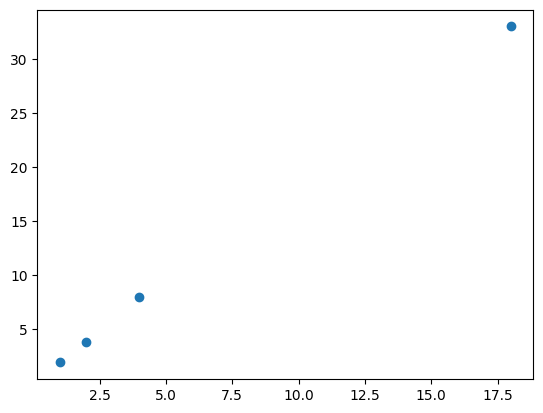

In [23]:
# `u` is twice `t`, plus a bit of randomness
u = t*2
u *= torch.randn_like(t)/10+0.95

plt.scatter(t, u);

In [24]:
prod = (t-t.mean())*(u-u.mean()); prod

tensor([ 51.29,  33.42,   8.42, 251.15])

In [25]:
prod.mean()

tensor(86.07)

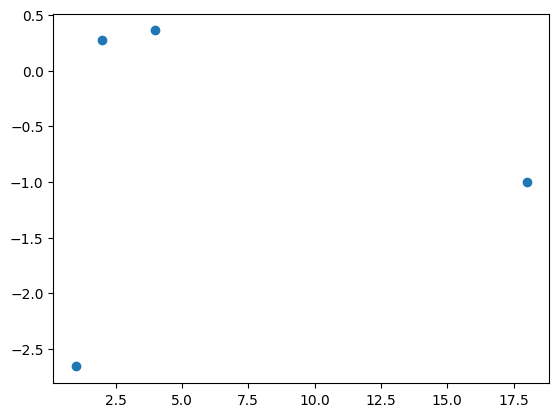

In [26]:
v = torch.randn_like(t)
plt.scatter(t, v);

In [27]:
((t-t.mean())*(v-v.mean())).mean()

tensor(0.05)

In [28]:
cov = (t*v).mean() - t.mean()*v.mean(); cov

tensor(0.05)

#### Pearson Correlation Coefficient

In [29]:
cov / (t.std() * v.std())

tensor(0.00)

#### Xavier init derivation

When we do `y = a @ x`, the coefficients of `y` are defined by

$$y_{i} = a_{i,0} x_{0} + a_{i,1} x_{1} + \cdots + a_{i,n-1} x_{n-1} = \sum_{k=0}^{n-1} a_{i,k} x_{k}$$

or in pure python code:
```
y[i] = sum([c*d for c,d in zip(a[i], x)])
```

or in numpy/pytorch code:
```
y[i] = (a[i]*x).sum()
```

At the very beginning, our `x` vector has a mean of roughly 0. and a standard deviation of roughly 1. (since we picked it that way).

In [30]:
x = torch.randn(100)
x.mean(), x.std()

(tensor(0.01), tensor(0.88))

If we go back to `y = a @ x` and assume that we chose weights for `a` that also have a mean of 0, we can compute the standard deviation of `y` quite easily. Since it's random, and we may fall on bad numbers, we repeat the operation 100 times.

In [32]:
mean,sqr = 0.,0.

for i in range(100):
    x = torch.randn(100)
    a = torch.randn(512, 100)
    y = a @ x
    mean += y.mean().item()
    sqr  += y.pow(2).mean().item()

mean/100, sqr/100

(0.026348070576786994, 100.32539909362794)

Now that looks very close to the dimension of our matrix 100. And that's no coincidence! When you compute y, you sum 100 product of one element of `a` by one element of `x`. So what's the mean and the standard deviation of such a product? We can show mathematically that as long as the elements in `a` and the elements in `x` are independent, the mean is 0 and the std is 1. This can also be seen experimentally:

In [33]:
mean,sqr = 0.,0.

for i in range(10000):
    x = torch.randn(1)
    a = torch.randn(1)
    y = a*x
    mean += y.item()
    sqr  += y.pow(2).item()

mean/10000, sqr/10000

(0.005235258344967224, 1.0566432541337023)

Then we sum 100 of those things that have a mean of zero, and a mean of squares of 1, so we get something that has a mean of 0, and mean of square of 100, hence `math.sqrt(100)` being our magic number. If we scale the weights of the matrix and divide them by this `math.sqrt(100)`, it will give us a `y` of scale 1, and repeating the product as many times as we want won't overflow or vanish.